# Projet d'Optimisation - Rangement d'un tuyau de jardin

# Enol Alvarez & Louis-Justin Tallot

## 1. Etude du problème d'optimisation

#### Q1) Interpréter le coût (4). Que cherche-t-on à minimiser ?

On cherche $min \left(K\left(x_N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum \limits _{i=0}^N y_i^2   \right)$

-> distance à l'horizontale + distance au parterre de fleurs

#### Q2) Pourquoi n'a-t-on pas plutôt imposé la contrainte $x_N = L/2$ ?

#### Q3) Interpréter géométriquement la condition de courbure (5)

On impose une courbure maximale avec : 

$$
    (x_{i+1} - 2x_i + x_{i-1})^2 + (y_{i+1} - 2y_i + y_{i-1})^2 \leq \text{d}x^4 \gamma^2
$$

En écrivant : 

#### Q4) Formuler le problème d'optimisation à résoudre sous la forme 

$$ \min \limits _{c_{eq}(z)=0,\; c_{ineq}(z)=0} f(z)$$

On pose : 

Variables de décision au nombre $n=2N+2$ : 
$$z = (x_0, \dots, x_N , y_0, \dots, y_N)$$  


Contraintes : 

 $$
\begin{align} 

c_{eq}(z) &= c_{eq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0, y_0, y_N , (x_1-x_0)^2 + (y_1-y_0)^2-\text{d}x^2, \dots, (x_N-x_{N-1})^2 + (y_N-y_{N-1})^2-\text{d}x^2)

\end{align}

 $$


 $$
\begin{align} 

c_{ineq}(z) &= c_{ineq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0-x_1, \dots, x_{N-1}-x_N, 
          (x_2-2x_1+x_0)^2+(y_2-2y_1+y_0)^2- \text{d} x ^4 \gamma ^2, \dots, 
        (x_N-2x_{N-1}+x_{N-2})^2+(y_N-2y_{N-1}+y_{N-2})^2- \text{d} x ^4 \gamma ^2)

\end{align}
 $$

Fonction objectif à minimiser : 

$$
\begin{align}
  f(z) &= f(x_0, \dots, x_N , y_0, \dots, y_N) \\
       &= K \left(( _N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum_{i=0}^N y_i^2 

\end{align}
$$



## 2. Etude et résolution numériques

#### Q5) Quelles méthodes de résolution peuvent être envisagées pour ce problème ?

#### Q6) Développer un algorithme de résolution pour les valeurs numériques suivantes : $L = 10$ ; $N = 60$ ; $K= 10$ et $\gamma = 3$

In [1]:
import casadi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.utils import io

In [2]:
# nos données
L = 10
N = 60
K = 10
gamma = 3

# on en déduit alors
dx = L/N

In [3]:
# Condition initiale - triangle rectangle isocèle
# les y d'abord
y = []
res = 0
while res <= L/(2*np.sqrt(2)):
    y.append(res)
    res += dx / (np.sqrt(2))

res = L/(2*np.sqrt(2)) - dx/(2*np.sqrt(2))
while res >= 0:
    y.append(res)
    res -= dx/np.sqrt(2)

# puis les x

x = []
res = 0

while res <= L/(np.sqrt(2)):
    x.append(res)
    res += dx/np.sqrt(2)
x.append(L/(np.sqrt(2)))

z0 = np.array(y+x)

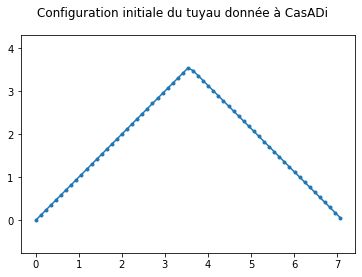

In [4]:
X = [z0[i] for i in range(N+1, 2*N+2)]
Y = [z0[i] for i in range(0, N+1)]
plt.plot(X, Y, marker='.')
plt.suptitle("Configuration initiale du tuyau donnée à CasADi")
plt.axis("equal")
plt.show()

In [25]:
def optim_simple(L=10, N=60, K=10, gamma=3, plot=True, verbose=False, must_return=False):
    dx = L/N

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K * (z[-1] - L/2)**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N] == 0) # y_N
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    


    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')

    if verbose:
        sol = opti.solve()
    else:
        with io.capture_output() as captured:
            sol = opti.solve()

    result = sol.value(z)

    if plot:
        plt.figure()
        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.')
        plt.axis('equal')
        plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")
        plt.show()

    if must_return:
        return result


In [26]:
# # on lance une optimisation avec CasADi
# opti = casadi.Opti()
# # nombre de variables : 
# n = 2 * N + 2
# # notre variable d'optimisation dans CasADi, avec nos notations : 
# z = opti.variable(n)
# # notre fonction à minimiser : 
# f = 0
# # on met les y d'abord : 
# for i in range(N+1):
#     f += dx**2 *z[i]**2

# f += K * (z[-1] - L/2)**2

# # on veut minimiser
# opti.minimize(f)
# # on rajoute les contraintes égalité
# opti.subject_to(z[0] == 0) # y_0
# opti.subject_to(z[N] == 0) # y_N
# opti.subject_to(z[N+1] == 0) # x_0

# for i in range(N):
#     opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

# # on rajoute les contraintes inégalité
# for i in range(N):
#     opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

# for i in range(N-1):
#     opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    



In [27]:
# # CI
# opti.set_initial(z,z0)

# # on résoud
# opti.solver('ipopt')
# sol = opti.solve()
# # print(sol.value(z))

In [8]:
# result = sol.value(z)
# X = [result[i] for i in range(N+1, 2*N+2)]
# Y = [result[i] for i in range(0, N+1)]
# plt.plot(X, Y, marker='.')
# plt.axis('equal')
# plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")
# plt.show()

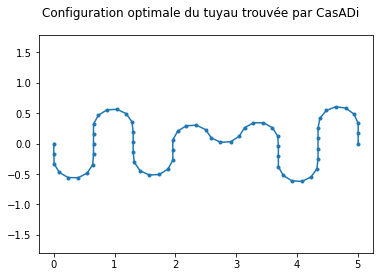

OptiSol(Opti {
  instance #12
  #variables: 1 (nx = 122)
  #parameters: 0 (np = 0)
  #constraints: 182 (ng = 182)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [24]:
optim_simple()

## 3. Modèle global

In [10]:
x_P = 2
y_P = 1.3
R = 1

In [28]:
def optim_avec_parterre(L=10, N=60, K=10, gamma=3, x_P=2, y_P=0.2, R=0.3, plot=True, verbose=False, must_return=False):
    dx = L/N

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K * (z[-1] - L/2)**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N] == 0) # y_N
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    

    # on rajoute le parterre de fleurs

    for i in range(N+1):
        opti.subject_to(R**2 - (x_P-z[N+1 +i])**2 - (y_P-z[i])**2  <= 0)
    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')
    if verbose:
        sol = opti.solve()
    else:
        with io.capture_output() as captured:
            sol = opti.solve()
    # print(sol.value(z))

    result = sol.value(z)

    if plot:
        plt.figure()
        # les couleurs pour que ça soit joli
        couleur_tuyau = "orange"
        # couleur_parterre = matplotlib.cm.gist_earth(0.6)
        couleur_parterre = matplotlib.cm.PiYG(0.999)


        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.', color=couleur_tuyau)
        plt.axis('equal')
        plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")

        parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)


        legende_tuyau = plt.Line2D(range(1), range(1),
                                marker="o", color=couleur_tuyau)


        # plt.legend(handles=[matplotlib.patches.Patch(color=couleur_tuyau, label="Tuyau")])

        line1 = plt.Line2D([], [], color=couleur_tuyau, 
                        marker='o',markersize=5, markerfacecolor=couleur_tuyau)
        line2 = plt.Line2D([], [], color="white", 
                        marker='o',markersize=20,markerfacecolor=couleur_parterre)
        plt.legend((line1,line2),('Tuyau','Parterre de fleurs à éviter'))#,numpoints=1, loc=1)
        plt.gca().add_artist(parterre_fleurs)
        plt.show()

    if must_return:
        return result

In [17]:
# # les couleurs pour que ça soit joli
# couleur_tuyau = "orange"
# # couleur_parterre = matplotlib.cm.gist_earth(0.6)
# couleur_parterre = matplotlib.cm.PiYG(0.999)


# result = sol.value(z)
# X = [result[i] for i in range(N+1, 2*N+2)]
# Y = [result[i] for i in range(0, N+1)]
# plt.plot(X, Y, marker='.', color=couleur_tuyau)
# plt.axis('equal')
# plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")

# parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)


# legende_tuyau = plt.Line2D(range(1), range(1),
#                            marker="o", color=couleur_tuyau)


# # plt.legend(handles=[matplotlib.patches.Patch(color=couleur_tuyau, label="Tuyau")])

# line1 = plt.Line2D([], [], color=couleur_tuyau, 
#                    marker='o',markersize=5, markerfacecolor=couleur_tuyau)
# line2 = plt.Line2D([], [], color="white", 
#                    marker='o',markersize=20,markerfacecolor=couleur_parterre)
# plt.legend((line1,line2),('Tuyau','Parterre de fleurs à éviter'))#,numpoints=1, loc=1)
# plt.gca().add_artist(parterre_fleurs)
# plt.show()

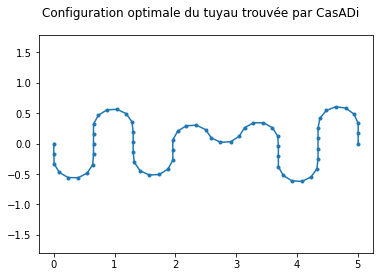

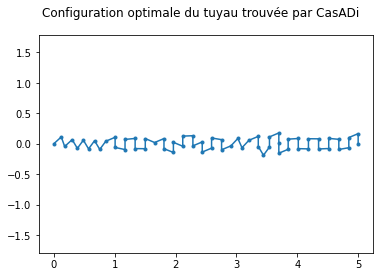

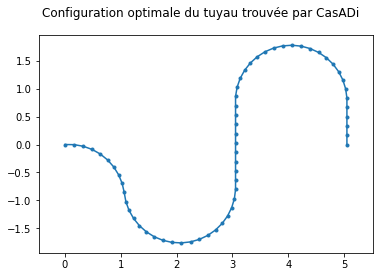

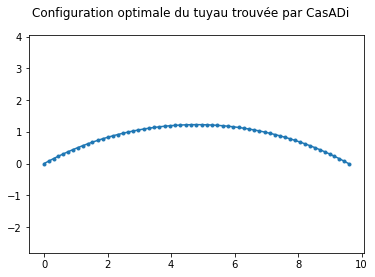

In [13]:
optim_simple()
optim_simple(gamma=10)
optim_simple(gamma=1)
optim_simple(gamma=0.1)

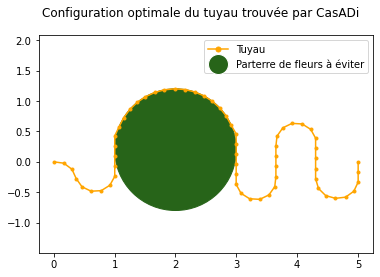

In [18]:
optim_avec_parterre(R=1)